In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [32]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [33]:
root_folder = 'CONV_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [34]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

prior_size = 100
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn(50, prior_size, 1, 1).to(device)
loss = nn.BCELoss()

cuda:0


In [36]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=2, stride=2, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), device=device):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride, bias=False))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        if activation_fn is not None:
            layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [37]:
class ConvTransposeLayer(nn.Module):
    def __init__(self, size, padding=2, stride=2, pool_layer=nn.MaxUnpool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), device=device):
        super(ConvTransposeLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, stride=stride, bias=False))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        if activation_fn is not None:
            layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [38]:
class Discriminator(nn.Module):
    def __init__(self, bn=False):
        super(Discriminator, self).__init__()
        self.conv1 = ConvLayer([1, 64, 6], pool_layer=None, activation_fn=nn.LeakyReLU(0.2), device=device)
        self.conv2 = ConvLayer([64, 128, 6], pool_layer=None, bn=bn, activation_fn=nn.LeakyReLU(0.2), device=device)
        self.conv3 = ConvLayer([128, 256, 5], pool_layer=None, bn=bn, activation_fn=nn.LeakyReLU(0.2), device=device)
        self.conv4 = ConvLayer([256, 512, 4], pool_layer=None, bn=bn, activation_fn=nn.LeakyReLU(0.2), device=device)
        self.conv5 = ConvLayer([512, 1, 3], pool_layer=None, activation_fn=nn.Sigmoid(), stride=2, padding=0, device=device)
        
    def forward(self, x):
        #print ('D1', x.shape)
        x = self.conv1(x)
        #print ('D2', x.shape)
        x = self.conv2(x)
        #print ('D3', x.shape)
        x = self.conv3(x)
        #print ('D4', x.shape)
        x = self.conv4(x)
        #print ('D5', x.shape)
        x = self.conv5(x)
        #print ('D6', x.shape)
        
        return x

In [39]:
class Generator(nn.Module):
    def __init__(self, bn=False):
        super(Generator, self).__init__()
        self.conv1 = ConvTransposeLayer([prior_size, 512, 3], pool_layer=None, bn=bn, activation_fn=nn.LeakyReLU(0.2), stride=2, padding=0, device=device)
        self.conv2 = ConvTransposeLayer([512, 256, 4], pool_layer=None, bn=bn, activation_fn=nn.LeakyReLU(0.2), device=device)
        self.conv3 = ConvTransposeLayer([256, 128, 5], pool_layer=None, bn=bn, activation_fn=nn.LeakyReLU(0.2), device=device)
        self.conv4 = ConvTransposeLayer([128, 64, 6], pool_layer=None, bn=bn, activation_fn=nn.LeakyReLU(0.2), device=device)
        self.conv5 = ConvTransposeLayer([64, 1, 6], pool_layer=None, activation_fn=nn.Tanh(), device=device)
        
    def forward(self, x):
        #print ('G1', x.shape)
        x = self.conv1(x)
        #print ('G2', x.shape)
        x = self.conv2(x)
        #print ('G3', x.shape)
        x = self.conv3(x)
        #print ('G4', x.shape)
        x = self.conv4(x)
        #print ('G5', x.shape)
        x = self.conv5(x)
        #print ('G6', x.shape)
        
        return x

In [40]:
G = Generator(bn=True)
D = Discriminator(bn=True)

G_optimizer = optim.Adadelta(G.parameters())
D_optimizer = optim.Adadelta(D.parameters())

In [41]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [42]:
batch_zeros = torch.zeros(batch_size).to(device)
batch_ones = torch.ones(batch_size).to(device)

In [43]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        
        z = torch.randn(batch_size, prior_size, 1, 1).to(device)
        
        fake_pred = D(G(z))
        
        fake_loss = loss(fake_pred.squeeze(), batch_zeros)
        
        true_pred = D(data)
        #print ('shape(true_pred)=', true_pred.shape)
        #print ('shape(true_pred.squeeze)=', true_pred.squeeze().shape)
        
        #print ('shape(batch_ones)=', batch_ones.shape)
        true_loss = loss(true_pred.squeeze(), batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn(batch_size, prior_size, 1, 1).to(device)
        #print ('z=',z)
        fake_pred = D(G(z))
        G_loss = loss(fake_pred.squeeze(), batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [44]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, _ in loader:
            z = torch.randn(batch_size, prior_size, 1, 1).to(device)
            fake_pred = D(G(z))
            true_pred = D(data)
        
            fake_loss = loss(fake_pred.squeeze(), batch_zeros).item()
            
            true_loss = loss(true_pred.squeeze(), batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += loss(fake_pred.squeeze(), batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    #fixed_gen = (G(fixed_z).cpu().detach() + 1) * 255 / 2
    fixed_gen = G(fixed_z).cpu().detach().numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 17.0551, D: 0.7432
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 3.3355, D: 0.2068
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 4.7197, D: 0.0109


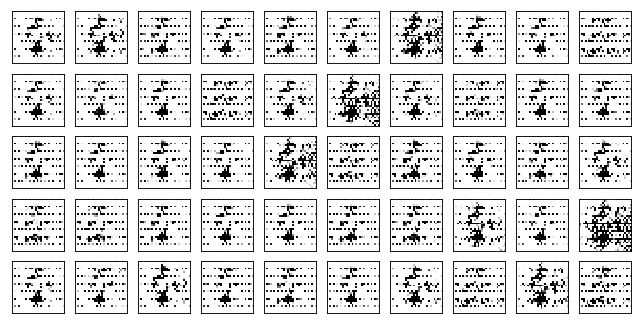

Test losses. G: 1.8098, D: 1.0160
Train Epoch: 2 [0/50000 (0%)]	Losses G: 3.9580, D: 0.0182
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 0.6382, D: 0.8927
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 3.5312, D: 0.8292


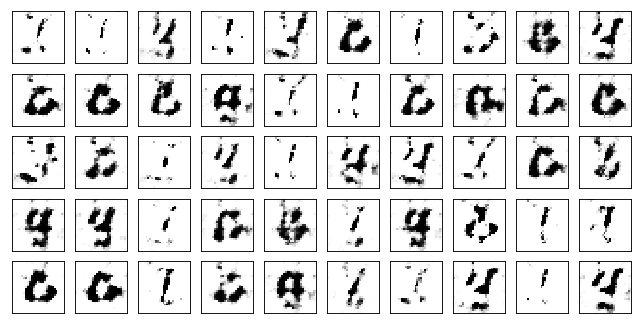

Test losses. G: 1.6511, D: 0.7188
Train Epoch: 3 [0/50000 (0%)]	Losses G: 0.4738, D: 0.8211
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 3.5746, D: 0.4832
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 0.7273, D: 0.7093


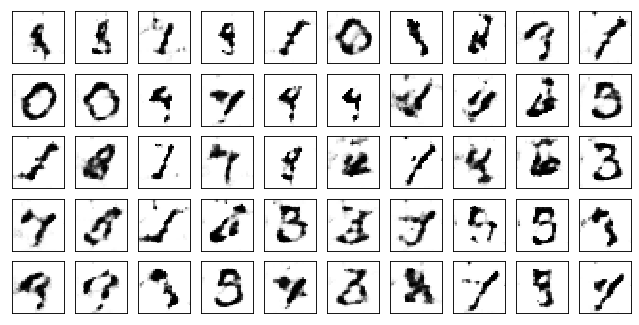

Test losses. G: 0.6559, D: 0.6650
Train Epoch: 4 [0/50000 (0%)]	Losses G: 2.9490, D: 0.7869
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 1.9060, D: 0.7756
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 3.1573, D: 0.9123


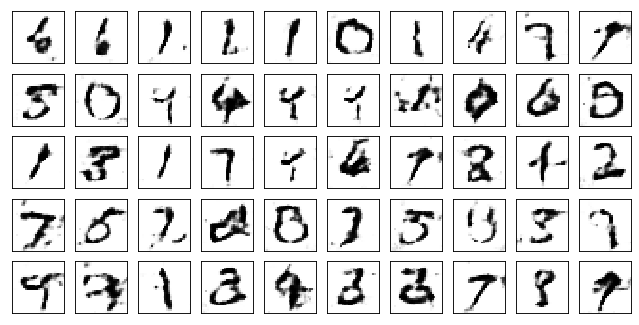

Test losses. G: 3.5933, D: 2.1932
Train Epoch: 5 [0/50000 (0%)]	Losses G: 0.7514, D: 1.1079
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 2.1080, D: 0.6635
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 2.0068, D: 0.5879


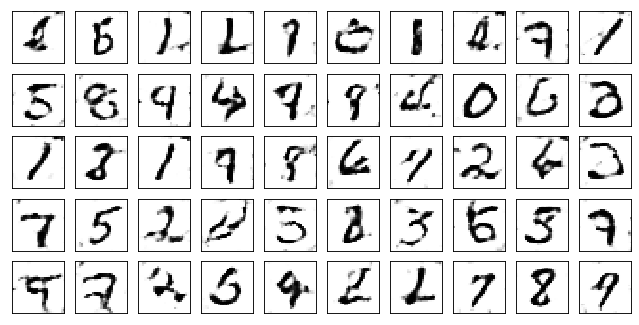

Test losses. G: 2.5512, D: 1.2528
Train Epoch: 6 [0/50000 (0%)]	Losses G: 0.8476, D: 0.6456
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 0.7301, D: 0.7814
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 0.9177, D: 0.4961


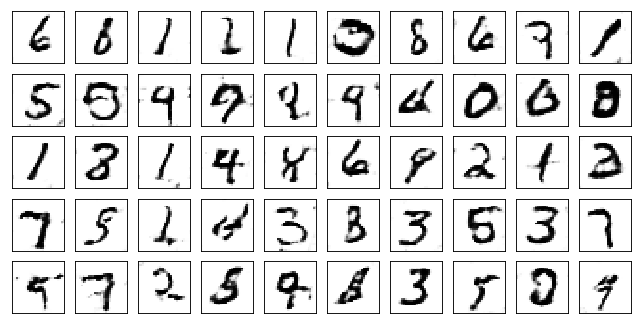

Test losses. G: 1.2831, D: 0.6366
Train Epoch: 7 [0/50000 (0%)]	Losses G: 2.2388, D: 0.5551
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 0.6975, D: 0.8073
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 1.1998, D: 0.5561


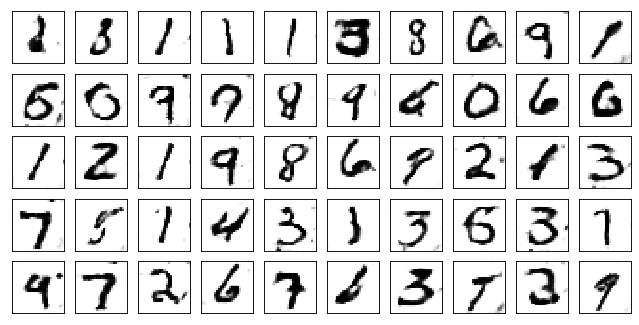

Test losses. G: 0.6341, D: 0.7570
Train Epoch: 8 [0/50000 (0%)]	Losses G: 2.0576, D: 0.4529
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 3.1732, D: 0.5010
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 2.4435, D: 0.4509


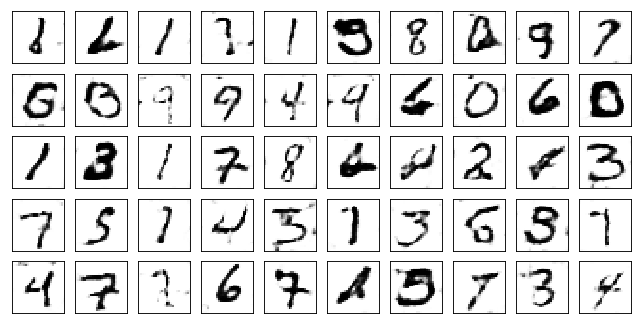

Test losses. G: 1.5810, D: 0.7403
Train Epoch: 9 [0/50000 (0%)]	Losses G: 1.7874, D: 0.4003
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 1.0238, D: 0.4386
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 1.2608, D: 0.3369


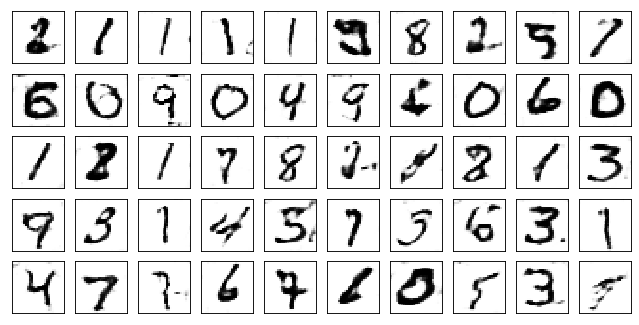

Test losses. G: 0.9966, D: 0.5656
Train Epoch: 10 [0/50000 (0%)]	Losses G: 2.7929, D: 0.3951
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 3.0061, D: 0.4248
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 0.6932, D: 0.4798


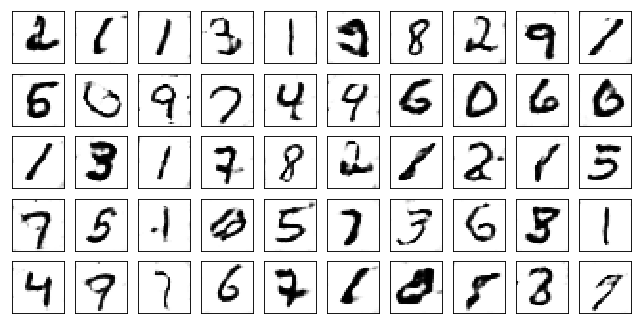

Test losses. G: 1.7551, D: 0.6949
Train Epoch: 11 [0/50000 (0%)]	Losses G: 3.7854, D: 0.6931
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 2.6667, D: 0.1624
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 1.6912, D: 0.5710


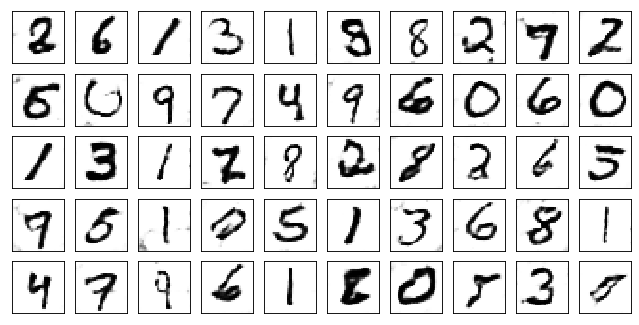

Test losses. G: 0.1912, D: 1.5107
Train Epoch: 12 [0/50000 (0%)]	Losses G: 3.0154, D: 0.5846
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 1.2323, D: 0.4047
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 1.4068, D: 0.1262


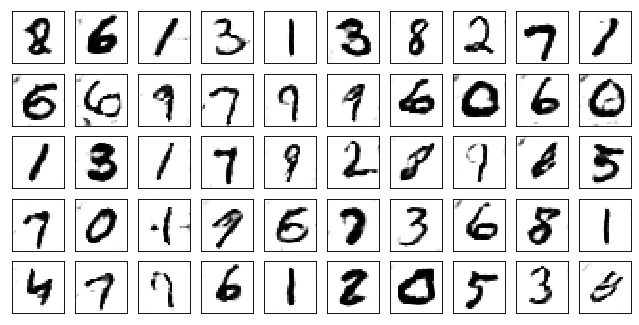

Test losses. G: 1.3286, D: 0.6947
Train Epoch: 13 [0/50000 (0%)]	Losses G: 6.5460, D: 0.3895
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 5.1512, D: 0.4834
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 0.5846, D: 1.4589


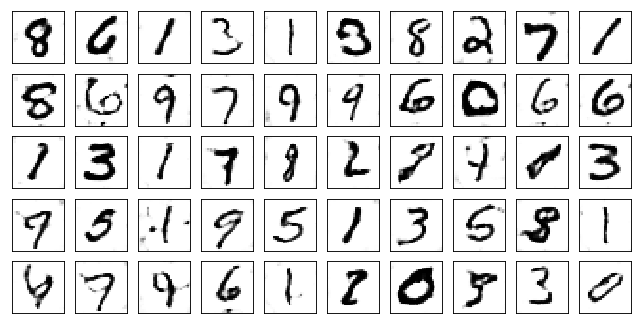

Test losses. G: 4.2528, D: 1.5700
Train Epoch: 14 [0/50000 (0%)]	Losses G: 4.6131, D: 0.7655
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 3.9214, D: 0.1389
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 7.7797, D: 0.3665


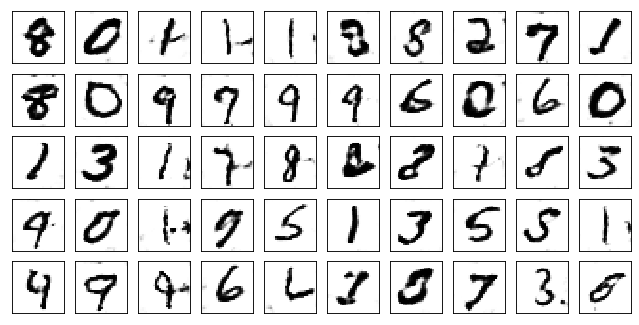

Test losses. G: 2.4414, D: 1.1874
Train Epoch: 15 [0/50000 (0%)]	Losses G: 2.0376, D: 0.9492
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 3.6165, D: 0.1145
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 1.3658, D: 0.2808


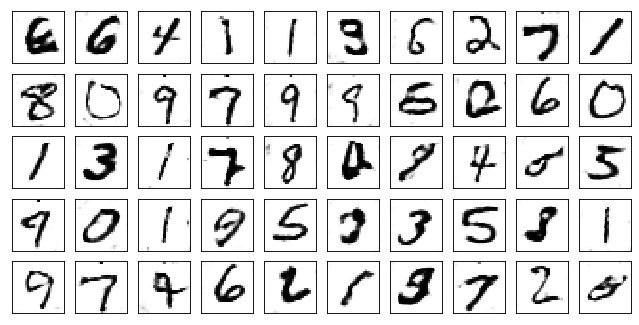

Test losses. G: 1.6150, D: 0.6925
Train Epoch: 16 [0/50000 (0%)]	Losses G: 5.9608, D: 0.4110
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 2.2468, D: 0.1323
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 3.3560, D: 0.1072


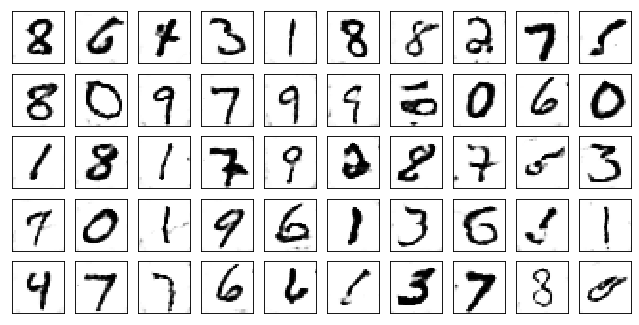

Test losses. G: 2.1447, D: 0.7802
Train Epoch: 17 [0/50000 (0%)]	Losses G: 3.1360, D: 0.0551
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 4.4355, D: 0.2344
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 5.6742, D: 0.0721


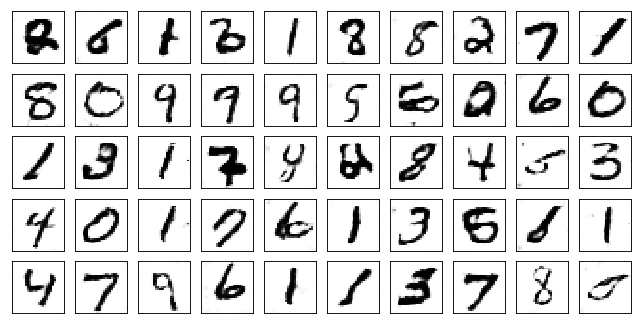

Test losses. G: 2.7428, D: 0.8614
Train Epoch: 18 [0/50000 (0%)]	Losses G: 4.2058, D: 0.0729
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 4.9777, D: 0.0934
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 3.8397, D: 0.1110


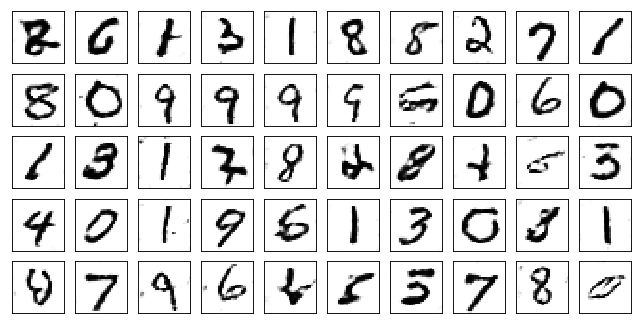

Test losses. G: 1.6155, D: 0.5705
Train Epoch: 19 [0/50000 (0%)]	Losses G: 3.3970, D: 0.0593
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 1.1564, D: 0.2460
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 4.5052, D: 0.0276


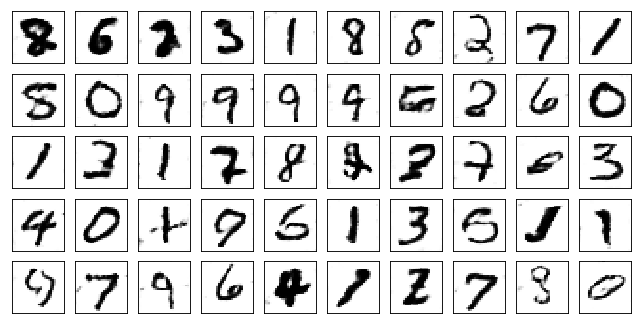

Test losses. G: 1.9910, D: 0.6578
Train Epoch: 20 [0/50000 (0%)]	Losses G: 3.6078, D: 0.0623
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 2.8400, D: 0.0451
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 5.0018, D: 0.0221


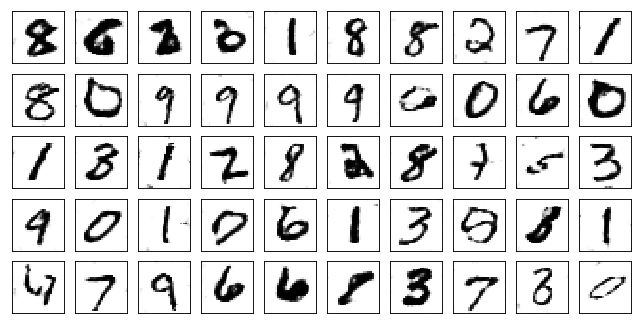

Test losses. G: 2.2420, D: 0.7273
Train Epoch: 21 [0/50000 (0%)]	Losses G: 4.3560, D: 0.0260
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 2.8450, D: 0.1138
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 5.7093, D: 0.0151


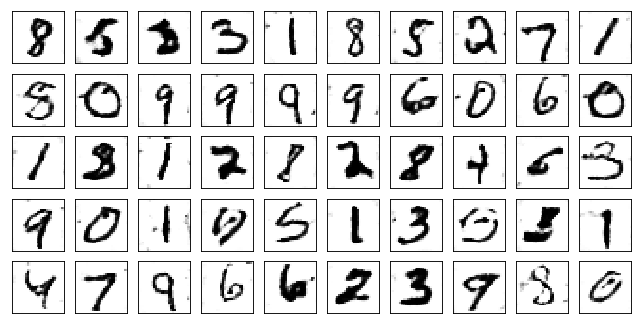

Test losses. G: 2.5406, D: 0.8450
Train Epoch: 22 [0/50000 (0%)]	Losses G: 4.6871, D: 0.0230
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 4.2127, D: 0.0141
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 7.9487, D: 0.3204


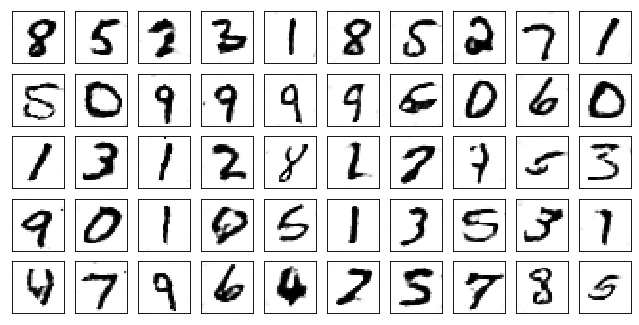

Test losses. G: 4.0493, D: 1.7043
Train Epoch: 23 [0/50000 (0%)]	Losses G: 1.1249, D: 0.5389
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 2.5345, D: 0.2625
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 3.7355, D: 0.0506


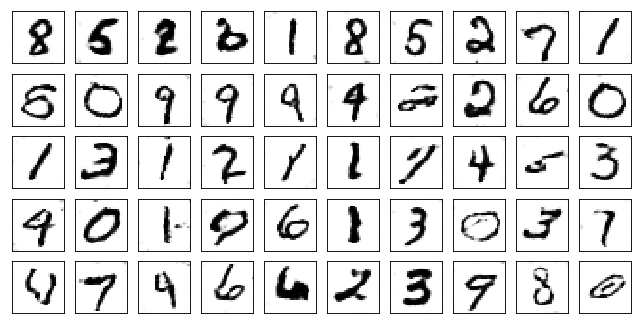

Test losses. G: 2.3538, D: 0.7781
Train Epoch: 24 [0/50000 (0%)]	Losses G: 3.7366, D: 0.0293
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 5.0472, D: 0.0577
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 4.7387, D: 0.0708


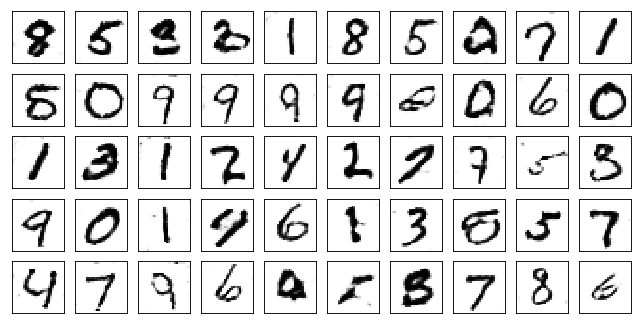

Test losses. G: 2.2364, D: 0.7081
Train Epoch: 25 [0/50000 (0%)]	Losses G: 5.4172, D: 0.0667
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 7.1647, D: 0.0856
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 1.3423, D: 0.1221


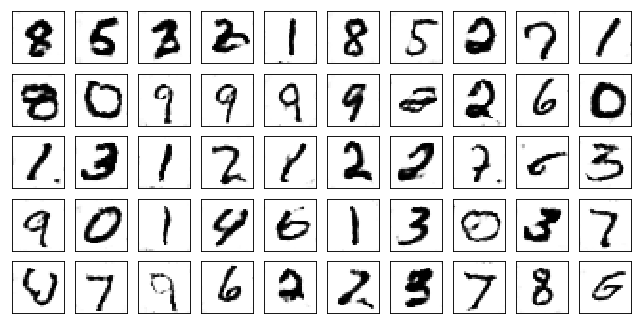

Test losses. G: 2.4342, D: 1.0941
Train Epoch: 26 [0/50000 (0%)]	Losses G: 9.7773, D: 0.5895
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 5.9309, D: 0.5556
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 3.1790, D: 0.0377


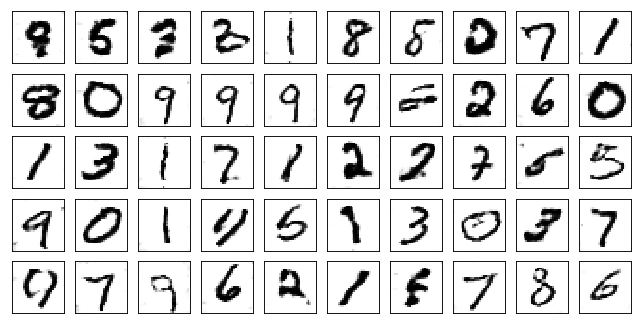

Test losses. G: 1.8753, D: 0.6517
Train Epoch: 27 [0/50000 (0%)]	Losses G: 6.0676, D: 0.0393
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 5.3436, D: 0.0265
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 3.5692, D: 0.0325


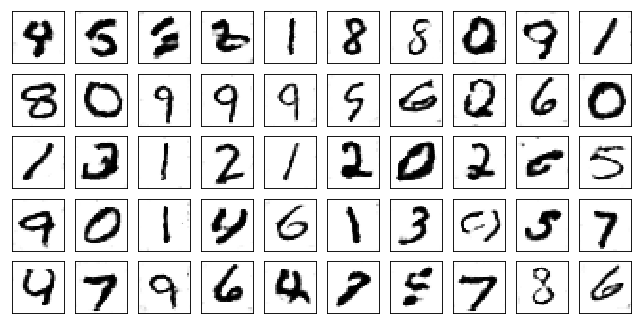

Test losses. G: 1.7287, D: 0.6214
Train Epoch: 28 [0/50000 (0%)]	Losses G: 4.9227, D: 0.0771
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 2.2713, D: 0.1579
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 4.1576, D: 0.0252


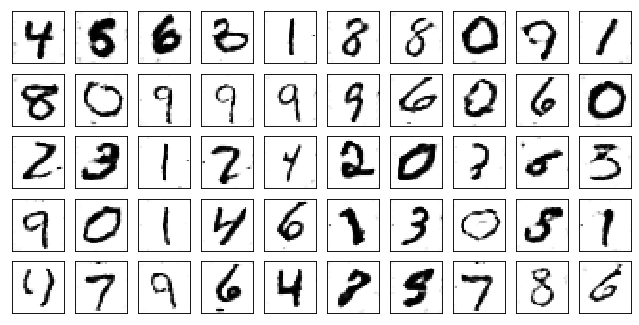

Test losses. G: 2.3514, D: 0.7198
Train Epoch: 29 [0/50000 (0%)]	Losses G: 3.7812, D: 0.0133
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 3.9396, D: 0.0502
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 2.3356, D: 0.3062


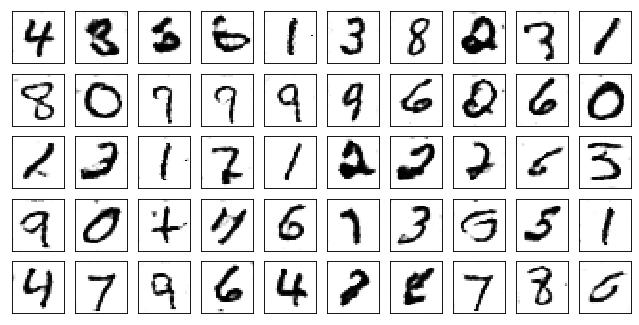

Test losses. G: 3.3537, D: 1.1963
Train Epoch: 30 [0/50000 (0%)]	Losses G: 9.4755, D: 0.5285
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 3.9400, D: 0.0341
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 4.6593, D: 0.0357


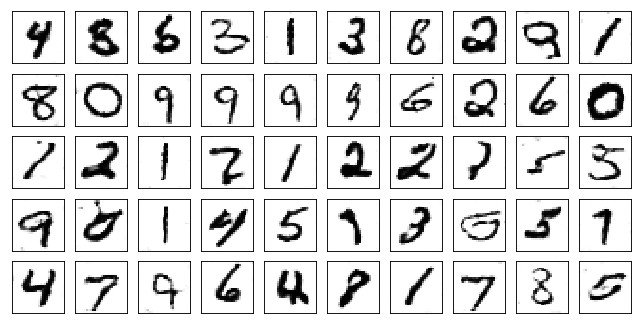

Test losses. G: 2.0837, D: 0.6509


In [45]:
for epoch in range(1, 31):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)